#### Model: 

\begin{eqnarray}
X_t & = & A X_{t-1} + \nu_t,
\\
Y_t & = & C X_t + \omega_t,
\\
\nu_t & \sim & \text{N}(0, Q ) ~~ \text{with} ~ Q = \sigma_x^2 I,
\\
\omega_t & \sim & \text{N}(0, R) ~~ \text{with} ~ R = \sigma_y^2 I.
\end{eqnarray}

In [1]:
from __future__ import division
%matplotlib inline
from pykalman import KalmanFilter
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, copy
from scipy.stats import *
from pylab import plot, show, legend
from tqdm import trange
from kalman import *

In [2]:
A = np.asarray([[1, 1], [0, 1]])
C = np.asarray([[0.1, 0.5], [-0.3, 0.0]])
dim = np.shape(A)[0]
sigmax2 = 1
sigmay2 = 1
Q = sigmax2*np.eye(dim)
R = sigmay2*np.eye(dim)
mu0 = np.zeros(dim)
Sigma0 = np.eye(dim)

In [3]:
T = 100
Y, X = generate_data_linear_gaussian(mu0, Sigma0, A, C, Q, R, T)

kf = KalmanFilter(initial_state_mean=mu0,
                  initial_state_covariance=Sigma0,
                  transition_matrices=A, 
                  observation_matrices=C, 
                  transition_covariance=Q, 
                  observation_covariance=R)
(filtered_state_means, filtered_state_covariances) = kf.filter(Y)

### Sanity checks:

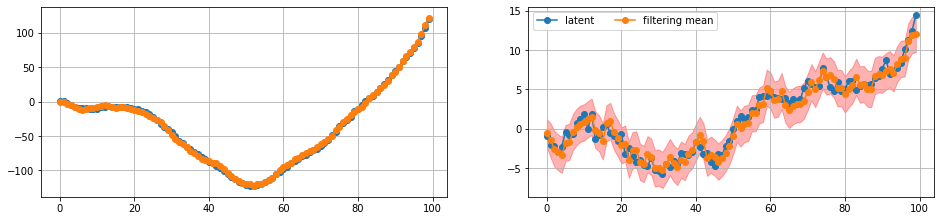

In [4]:
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i],  "o-", label="latent")
    plt.plot(filtered_state_means[:,i], "o-", label="filtering mean")
    plt.fill_between(np.arange(T), 
                     filtered_state_means[:,i] + 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     filtered_state_means[:,i] - 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     color='red', alpha=0.3)
    plt.grid(True)
plt.legend(ncol=2)

In [5]:
aa = np.exp(np.linspace(-20,20,1000))
lls = np.zeros(len(aa))
for (i,a) in enumerate(aa) :
    lls[i] = log_likelihood(Y, A, C, sigmax2, a, mu0, Sigma0)

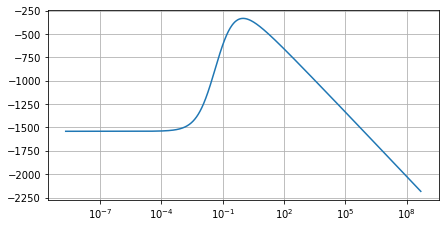

In [6]:
plt.rcParams['figure.figsize'] = (7, 3.5)
plt.plot(aa, lls)
plt.xscale('log')
plt.grid(True)

### MCMC:

In [7]:
n_mcmc = 10_000
scale = 0.3

In [8]:
power = 1
log_sigmay2_chain_pow1, log_sigmax2_chain_pow1, accepted_pow1, scales_pow1 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/power, power=power)

100%|██████████| 10000/10000 [05:56<00:00, 28.07it/s]


In [9]:
power = 5
log_sigmay2_chain_pow5, log_sigmax2_chain_pow5, accepted_pow5, scales_pow5 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/power, power=power)

100%|██████████| 10000/10000 [05:24<00:00, 30.84it/s]


In [10]:
power = 20
log_sigmay2_chain_pow20, log_sigmax2_chain_pow20, accepted_pow20, scales_pow20 \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/power, power=power)

100%|██████████| 10000/10000 [06:37<00:00, 11.11it/s]


In [11]:
accepted_pow1/n_mcmc, accepted_pow5/n_mcmc, accepted_pow20/n_mcmc

(0.2955, 0.3424, 0.3823)

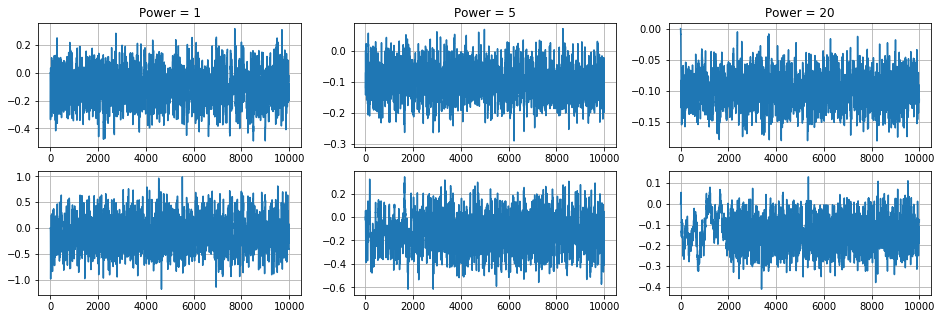

In [12]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.subplot(231)
plt.plot(log_sigmay2_chain_pow1)
plt.grid(True)
plt.title("Power = 1")
plt.subplot(232)
plt.plot(log_sigmay2_chain_pow5)
plt.grid(True)
plt.title("Power = 5")
plt.subplot(233)
plt.plot(log_sigmay2_chain_pow20)
plt.grid(True)
plt.title("Power = 20")

plt.subplot(234)
plt.plot(log_sigmax2_chain_pow1)
plt.grid(True)
plt.subplot(235)
plt.plot(log_sigmax2_chain_pow5)
plt.grid(True)
plt.subplot(236)
plt.plot(log_sigmax2_chain_pow20)
plt.grid(True)

In [13]:
print(np.round(np.var(log_sigmay2_chain_pow1)/np.var(log_sigmay2_chain_pow5),1), 
      np.round(np.var(log_sigmax2_chain_pow1)/np.var(log_sigmax2_chain_pow5),1))
print(np.round(np.var(log_sigmay2_chain_pow1)/np.var(log_sigmay2_chain_pow20),1),
      np.round(np.var(log_sigmax2_chain_pow1)/np.var(log_sigmax2_chain_pow20),1))

5.5 4.4
21.8 16.8


In [23]:
print(np.round([np.mean(np.exp(log_sigmay2_chain_pow1)), 
                np.mean(np.exp(log_sigmay2_chain_pow5)), 
                np.mean(np.exp(log_sigmay2_chain_pow20))],2))
print(np.round([np.mean(np.exp(log_sigmax2_chain_pow1)), 
                np.mean(np.exp(log_sigmax2_chain_pow5)), 
                np.mean(np.exp(log_sigmax2_chain_pow20))],2))

-0.09696733901616768 -0.09494542875837783 -0.09433516329572965
-0.23678831248959398 -0.29957518819347934 -0.2990154530377581
